In [7]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name, dt):
    v = numpy.loadtxt(file_name)

    #u = numpy.array(v[:, 1:3])
    u = numpy.array(v[:, 3:5])
    x = numpy.array(v[:, 5:7])

    t = numpy.arange(x.shape[0])*dt
    
    return u, x, t

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x):   
    #zero initial conditions
    x_aug = x - x[0]

    vel = difference(x_aug[:, 0:2])

    x_aug = numpy.concatenate([x_aug, vel], axis=1)

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()

    axis_count = 4
    if x_ref.shape[1] == 4:
        axis_count+= 2

    fig, axs = plt.subplots(axis_count, 1, figsize=(8, 2*5))


    u_result*= 60.0/(2.0*numpy.pi)


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control left")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control right")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [mm]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1]*180.0/numpy.pi, color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1]*180.0/numpy.pi, color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [deg]")
    axs[3].grid()


    if axis_count == 6:
        axs[4].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 2], label="ground truth", color="red")
        axs[4].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 2], label="prediction", color="blue")
        axs[4].set_xlabel("time [s]")
        axs[4].set_ylabel("distance velocity")
        axs[4].legend()
        axs[4].grid()

        axs[5].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 3]*180.0/numpy.pi, color="red")
        axs[5].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 3]*180.0/numpy.pi, color="blue")
        axs[5].set_xlabel("time [s]")
        axs[5].set_ylabel("angle velocity")
        axs[5].grid()
        
    

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [8]:
#obtain model
dt = 1.0/250.0
u_result, x_result, t_result = load_from_file("./data/run_0.log", dt)


#normalise speed

x_ref = state_augmentation(x_result.copy())

 


#identification
#a_est, b_est = LibsControl.rls_identification(u_result, x_ref)
a_est, b_est = LibsControl.krls_identification(u_result, x_ref)


c_est = numpy.eye(a_est.shape[0])
    


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")


#symmetrise model (optional) - fix imperfection in identification

a_est[numpy.abs(a_est) < 10**-2] = 0.0

a_est[0, 0] = 1.0
a_est[1, 1] = 1.0
a_est[0, 3] = 0.0
a_est[2, 3] = 0.0 


b_est_flip = numpy.flip(b_est, axis=1).copy()
b_est_flip[1, :]*= -1
b_est_flip[3, :]*= -1
b_est = (b_est + b_est_flip)/2.0

print("symmetrised model\n")
print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")



n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]


mat_a = 
 [[ 9.99664884e-01 -3.20147669e-04  7.54359751e-01  6.73529678e-01]
 [-7.24903596e-07  1.00023043e+00 -2.50066438e-04 -6.60984457e-02]
 [-3.34677072e-04 -3.19780287e-04  7.54308788e-01  6.72772368e-01]
 [-5.68974056e-07  2.31760672e-04 -2.50002081e-04 -6.65089594e-02]] 


mat_b = 
 [[ 3.00263004  2.64051084]
 [-0.28549028  0.29146864]
 [ 3.0031842   2.64134811]
 [-0.2855897   0.29163322]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 


symmetrised model

mat_a = 
 [[ 1.          0.          0.75435975  0.        ]
 [ 0.          1.          0.         -0.06609845]
 [ 0.          0.          0.75430879  0.        ]
 [ 0.          0.          0.         -0.06650896]] 


mat_b = 
 [[ 2.82157044  2.82157044]
 [-0.28847946  0.28847946]
 [ 2.82226616  2.82226616]
 [-0.28861146  0.28861146]] 




<Figure size 640x480 with 0 Axes>

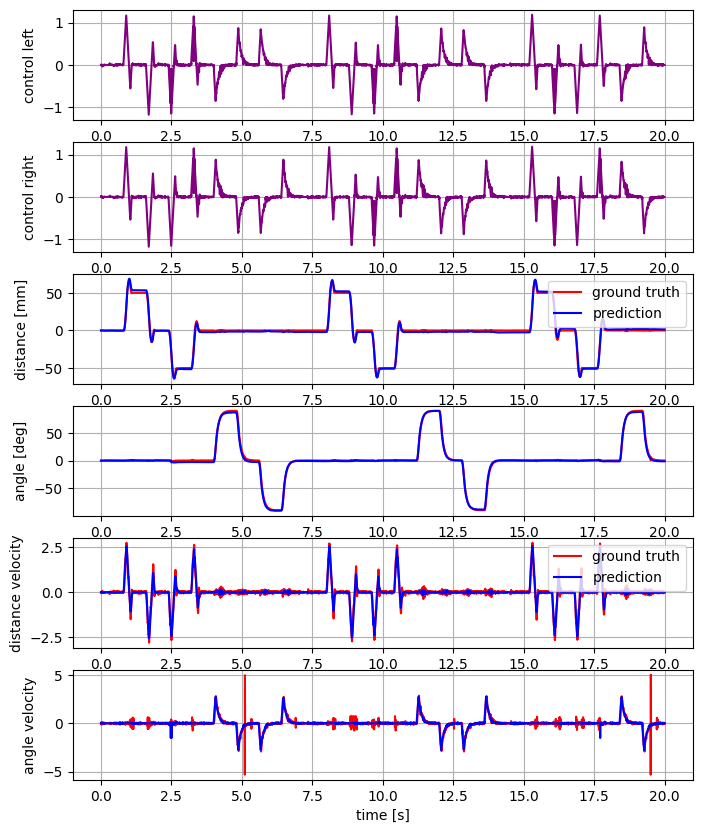

In [9]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, c_est)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)


#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 5000)


In [10]:
#controller synthetis

#create loss weighting matrices (diagonal)
#q = numpy.diag([ 10**-7, 0.5*(10**-3), 0.0, 0.0] )
#q = numpy.diag([ 10**-6, 0.5*(10**-3), 0.0, 0.0] )
q = numpy.diag([ 5*10**-6, 0.5*(10**-3), 0.0, 0.0] )
r = numpy.diag( [1.0, 1.0])  


noise_q = 0.001*numpy.eye(4)
noise_r = 0.001*numpy.diag([50.325, 0.019,  0.000, 0.000])
    

#solve LQG controller 
lqg = LibsControl.LQGDiscrete(a_est, b_est, c_est, q, r, noise_q, noise_r, 1.0)

print("controller")
print("k  = \n", lqg.k, "\n")
print("ki = \n", lqg.ki, "\n")
print("f  = \n", lqg.f, "\n")
print("\n\n")


print("poles OL = ", numpy.linalg.eigvals(a_est))
print("poles CL = ", numpy.linalg.eigvals(a_est - b_est@lqg.k))



controller
k  = 
 [[ 0.01763181 -0.25733829  0.0341388   0.01496745]
 [ 0.01763181  0.25733829  0.0341388  -0.01496745]] 

ki = 
 [[ 0.00179736 -0.01688071  0.          0.        ]
 [ 0.00179736  0.01688071  0.          0.        ]] 

f  = 
 [[0.13137825 0.         0.         0.        ]
 [0.         0.98168943 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]] 




poles OL =  [ 1.          1.          0.75430879 -0.06650896]
poles CL =  [ 0.73105622+0.16489876j  0.73105622-0.16489876j -0.06716051+0.j
  0.86081749+0.j        ]


<Figure size 640x480 with 0 Axes>

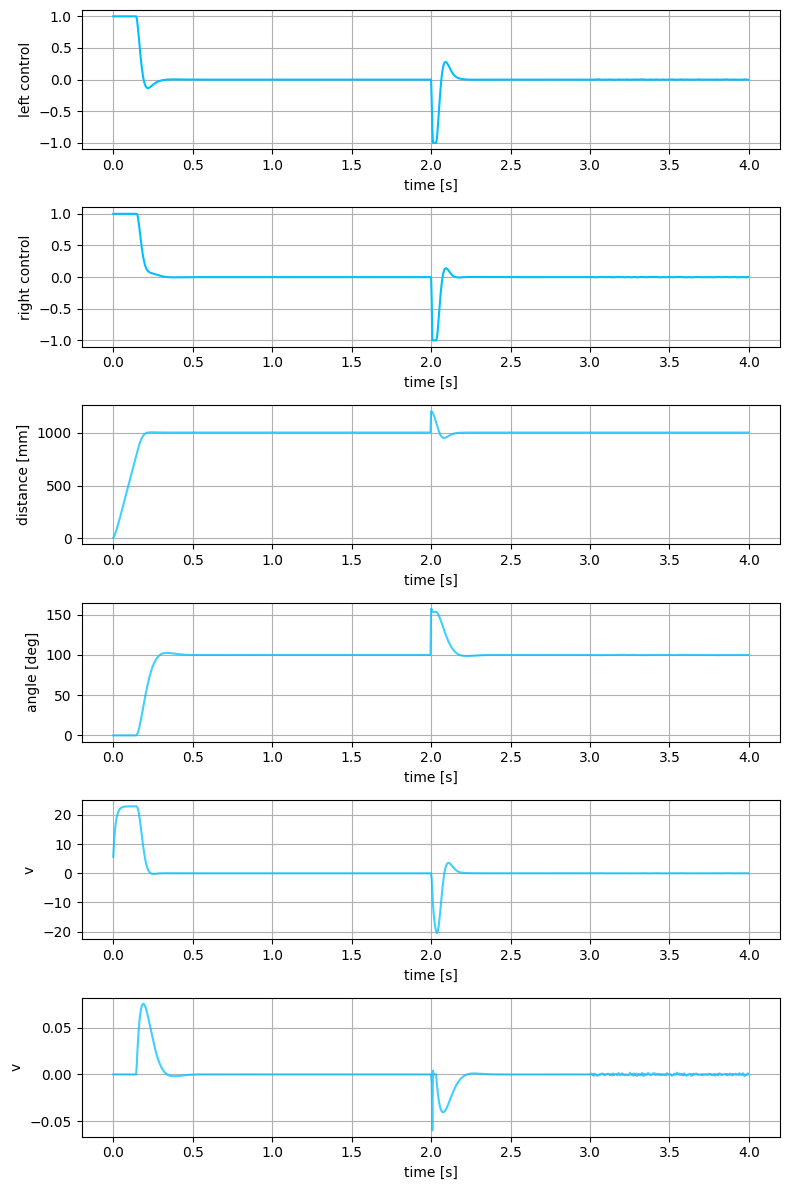

In [11]:
#process simulation

n_max = int(4.0/dt)

#required output, 1 meter, 100degrees
xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0, 0.0, 0.0]]).T

#plant state
x = numpy.zeros((a_est.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((b_est.shape[1], 1))

x_hat = numpy.zeros(x.shape)

#result log
t_result = [] 
u_result = []
x_result = []
int_result = []



for n in range(n_max):

    if n > 0.75*n_max:
        noise = numpy.diagonal(noise_r)**0.5
        noise = numpy.expand_dims(noise, 1)
        x_obs = x + noise*numpy.random.randn(x.shape[0], x.shape[1])
    else:
        x_obs = x

    #compute controller output
    u, integral_action, x_hat = lqg.forward(xr, x_obs, integral_action, x_hat)

    #disturbance
    '''
    if n > n_max//2:
        u[0, :]+= 50
        u[1, :]+= 100
    '''

    if n == n_max//2:
        x[0, 0]+= 200
        x[1, 0]+= 1

    

    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    int_result.append(integral_action[:, 0].copy())
    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)

int_result = numpy.array(int_result)



#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_discrete_output.png", u_labels = ["left control", "right control"], x_labels = ["distance [mm]", "angle [deg]", "v", "v"])




In [12]:
#print c-like arrays
print(matrix_to_c("a",  a_est))
print(matrix_to_c("b",  b_est))
print(matrix_to_c("c",  c_est))
print(matrix_to_c("k",  lqg.k))
print(matrix_to_c("ki", lqg.ki))
print(matrix_to_c("f",  lqg.f))




float a[] = {
		1.0, 0.0, 0.7543597, 0.0, 
		0.0, 1.0, 0.0, -0.066098444, 
		0.0, 0.0, 0.75430876, 0.0, 
		0.0, 0.0, 0.0, -0.066508956 };

float b[] = {
		2.8215704, 2.8215704, 
		-0.28847945, 0.28847945, 
		2.822266, 2.822266, 
		-0.28861147, 0.28861147 };

float c[] = {
		1.0, 0.0, 0.0, 0.0, 
		0.0, 1.0, 0.0, 0.0, 
		0.0, 0.0, 1.0, 0.0, 
		0.0, 0.0, 0.0, 1.0 };

float k[] = {
		0.017631808, -0.2573383, 0.034138802, 0.014967455, 
		0.017631808, 0.2573383, 0.034138802, -0.014967455 };

float ki[] = {
		0.0017973566, -0.016880713, 0.0, 0.0, 
		0.0017973566, 0.016880713, 0.0, 0.0 };

float f[] = {
		0.13137825, 0.0, 0.0, 0.0, 
		0.0, 0.98168945, 0.0, 0.0, 
		0.0, 0.0, 1.0, 0.0, 
		0.0, 0.0, 0.0, 1.0 };

